In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.transform import resize
import matplotlib.patches as patches
from scipy.ndimage.filters import gaussian_filter as gf

from hyss_util import *

In [2]:
# -- load both 2013 and 2018 scan
imgL_hsi0_half0 = np.load("../output/filtered_hsi0_half0.npy")
imgL_hsi0_half1 = np.load("../output/filtered_hsi0_half1.npy")
hsi0 = np.hstack([imgL_hsi0_half0, imgL_hsi0_half1])

imgL_hsi1_half0 = np.load("../output/filtered_hsi1_half0.npy")
imgL_hsi1_half1 = np.load("../output/filtered_hsi1_half1.npy")
hsi1 = np.hstack([imgL_hsi1_half0, imgL_hsi1_half1])

In [3]:
# -- get mean brightness images and save them
imgL_hsi0 = hsi0.mean(axis = 0)
imgL_hsi1 = hsi1.mean(axis = 0)


np.save("../output/hsi0_filter_mean.npy", imgL_hsi0)
np.save("../output/hsi1_filter_mean.npy", imgL_hsi1)



In [4]:
imgL_hsi0 =  np.load("../output/hsi0_filter_mean.npy")
imgL_hsi1 =  np.load("../output/hsi1_filter_mean.npy")

In [5]:
# -- get the overlapping are
img_L1 = (resize(imgL_hsi1.astype(float), (695, 1252)))[:, 165:1252]
img_L0 = imgL_hsi0[238:933, 0:1087]
nrow, ncol = img_L0.shape

In [6]:
# -- calculate the slope and offset for sensor sensitivity correction
slp, off = np.polyfit(img_L1[420:465, 150:200].flatten().clip(-5, 5), img_L0[420:465, 150:200].flatten().clip(-5, 5), 1)
img3 = img_L1 * slp + off + np.random.randn(nrow, ncol) * 0.19

# -- save reshaped imgL0 and imgL3
np.save("../output/graham_hall_upload/imgL0_overlap.npy", img_L0)
#np.save("../output/graham_hall_upload/img3_overlap.npy", img3)

# -- we load img3 here because the number of sources calculate by above formula will have some differences
img3 = np.load("../output/graham_hall_upload/img3_overlap.npy")

In [11]:
specs = np.load("../output/graham_hall_upload/hsi0_overlap_cnn_allwave.npy")
specs.shape       

(872, 14680)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


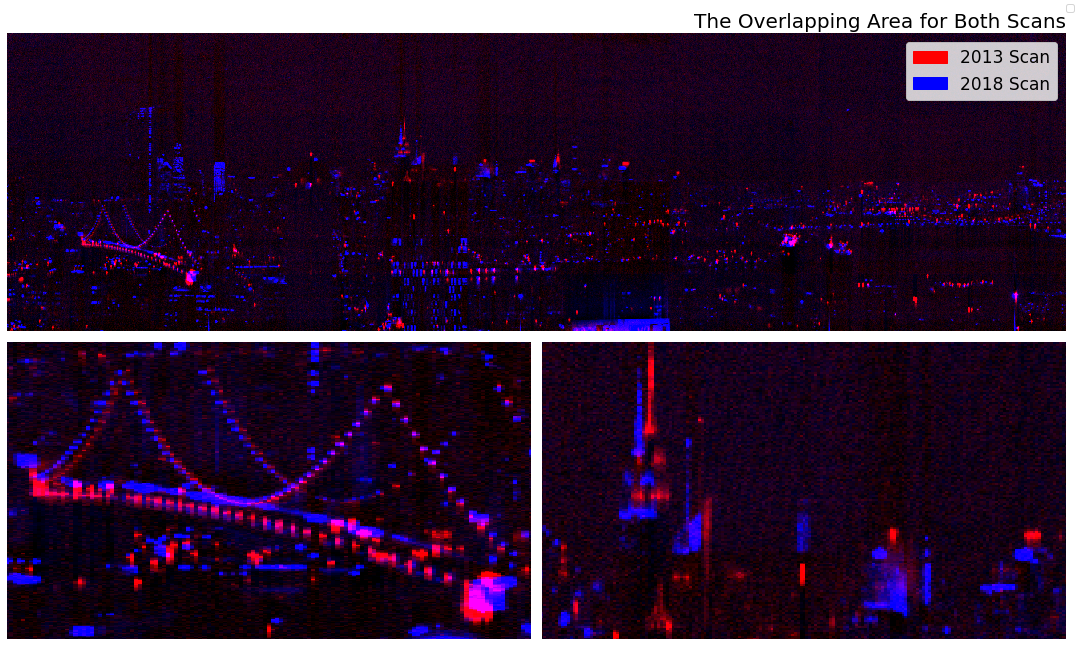

In [7]:
# -- create a 3-channel image

# -- make a 3-channel image
red = (img_L0.clip(-5, 5) + 5) / 10
blu = (img_L1.clip(-5, 5) + 5) / 10
rgb = np.dstack((red, np.zeros_like(red), blu))

rgb = (3*rgb - 1.4).clip(0, 1)


fig, ax = plt.subplots(figsize=(15, 9))

ax1 = plt.subplot(2,1,1)
ax1.imshow(rgb, interpolation="nearest", aspect="auto")
ax1.set_title("The Overlapping Area for Both Scans", loc='right', fontsize=20)
ax2 = plt.subplot(2,2,3)
ax3 = plt.subplot(2,2,4)
ax2.imshow(rgb, interpolation="nearest", aspect="auto")
ax3.imshow(rgb, interpolation="nearest", aspect="auto")
# ax[2].imshow(rgb, interpolation="nearest", aspect="auto")
ax2.set_ylim(600, 380)
ax2.set_xlim(70, 200)
ax3.set_ylim(350, 200)
ax3.set_xlim(370, 550)

axes = [ax1, ax2, ax3]
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
fig.legend()# add legend, upper right 
fig.tight_layout()

df_legend = pd.DataFrame([
                          [0, [255, 0, 0], '2013 Scan'],
                            [1, [0, 0, 255], '2018 Scan'],
    
                          ],
                         columns=['key', 'color', 'name'])

handles_1 = [patches.Rectangle((0, 0), 1, 1, color=[c / 255 for c in color_list]) for color_list in df_legend['color']]
labels = df_legend['name']

ax1.legend(handles_1, labels, loc='upper right', ncol=1, fontsize=17)

fig.tight_layout()

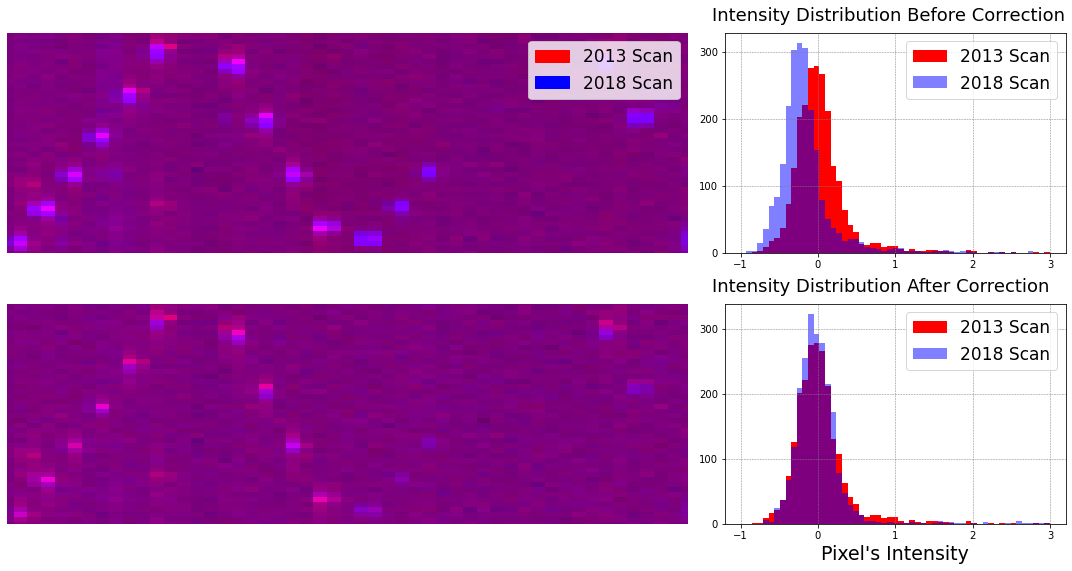

In [36]:
# -- make a 3-channel image (this is after sensor sensitivity correction)
rgb = np.dstack((red, np.zeros_like(red), blu))
rgb1 = np.dstack((red1, np.zeros_like(red1), blu1))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (15, 8), gridspec_kw={'width_ratios': [2, 1]})


ax[0, 0].imshow(rgb, interpolation="nearest", aspect="auto")
ax[1, 0].imshow(rgb1, interpolation="nearest", aspect="auto")
ax[0, 0].axis('off')
ax[1, 0].axis('off')

ax[0, 0].set_ylim(465, 420)
ax[0, 0].set_xlim(150, 200)

ax[1, 0].set_ylim(465, 420)
ax[1, 0].set_xlim(150, 200)


ax[0, 1].hist(img_L0[420:465, 150:200].flatten(), bins=55, range = (-1, 3), color = "red")
ax[0, 1].hist(img_L1[420:465, 150:200].flatten(), bins=55,  range = (-1, 3), alpha=0.5, color = "blue");
ax[0, 1].grid(color = 'grey', linestyle = '--', linewidth = 0.5)

ax[1, 1].hist(img_L0[420:465, 150:200].flatten(), bins=55,  range = (-1, 3), color = "red")
ax[1, 1].hist(img3[420:465, 150:200].flatten(), bins=55, alpha=0.5,range = (-1, 3),  color = "blue");
ax[1, 1].grid(color = 'grey', linestyle = '--', linewidth = 0.5)
fig.text(0.663, 0.97, 'Intensity Distribution Before Correction', va='center', fontsize = 18)
fig.text(0.663, 0.50, 'Intensity Distribution After Correction', va='center', fontsize = 18)
fig.subplots_adjust(hspace=8)


ax[0, 1].legend(['2013 Scan', '2018 Scan'], fontsize=17)
ax[1, 1].legend(['2013 Scan', '2018 Scan'], fontsize=17)
ax[0, 1].set_yticks(np.arange(0, 400, 100))
ax[1, 1].set_yticks(np.arange(0, 400, 100))
ax[0, 1].set_xticks(np.arange(-1, 4, 1))
ax[1, 1].set_xticks(np.arange(-1, 4, 1))
ax[1, 1].set_xlabel("Pixel's Intensity", fontsize=19)

df_legend = pd.DataFrame([
                          [0, [255, 0, 0], '2013 Scan'],
                            [1, [0, 0, 255], '2018 Scan'],
    
                          ],
                         columns=['key', 'color', 'name'])

handles_1 = [patches.Rectangle((0, 0), 1, 1, color=[c / 255 for c in color_list]) for color_list in df_legend['color']]
labels = df_legend['name']

ax[0, 0].legend(handles_1, labels, loc='upper right', ncol=1, fontsize=17,)

fig.tight_layout()

In [8]:
# -- get active source location and spec for both 2013 and 2018 hyperspectral scan
# -- if raw file exists, read it, create file if not
dname = "../output/hsi0_overlap_cnn_allwave.npy" 

if os.path.isfile(dname):

  print("Active source file for the 2013 scan is existed")

else:
  dpath0 = os.path.join(os.environ["LTCO_HSI0"], "full frame 20ms faster_VNIR.raw")
  # -- read 2013 scan and then get raw spectra data for these sources
  cube = read_hyper(dpath0)

  # -- manually set threshold and apply gf
  imgL0_gf = gf(1.0 * (img_L0 > 0.7), 1) > 0.25
  imgL0_overlap = 1.0 * np.array(imgL0_gf)

  # -- get raw spec data for 'active' pixel
  img_data = cube.data

  spec = []
  for i in range(len(img_data)):
    spec.append(img_data[i][238:933, 0:1087][imgL0_gf])

  spec = np.vstack(spec)
  np.save("../output/hsi0_overlap_cnn_allwave.npy", spec)


  # -- get location for 'active' pixel and  save it
  hsi0_indices = np.argwhere(imgL0_overlap == 1)
  hsi0_indices

  np.save("../output/hsi0_overlap_location.npy", hsi0_indices)


reading and parsing full frame 20ms faster_VNIR.hdr...
reading full frame 20ms faster_VNIR.raw...


In [9]:
# -- if raw file exists, read it, create file if not
dname = "../../output/hsi1_overlap_cnn_allwave.npy" 

if os.path.isfile(dname):

  print("Active source file for the 2018 scan is existed")

else: 
 
  # -- read 2018 scan and then get raw spectra data for these sources
  dpath = os.path.join(os.environ["LTCO_HSI1"], "night_00000.raw")
  cube = read_hyper(dpath)

  # -- manually set threshold and apply gf
  imgL1_gf = gf(1.0 * (img3 > 0.7), 1) > 0.25
  imgL1_overlap = 1.0 * np.array(imgL1_gf)

  # -- get raw spec data for 'active' pixel
  img_data = cube.data

  spec = []
  for i in range(len(img_data)):
    spec.append(((resize(img_data[i], (695, 1252)))[:, 165:1252])[imgL1_gf])

  spec = np.vstack(spec)
  np.save("../output/hsi1_overlap_cnn_allwave.npy", spec)


  # -- get location for 'active' pixel and then save it
  hsi1_indices = np.argwhere(imgL1_overlap == 1)

  np.save("../output/hsi1_overlap_location.npy", hsi1_indices)

reading and parsing night_00000.hdr...
reading night_00000.raw...


In [10]:
spec = np.load("../output/hsi0_overlap_cnn_allwave.npy")
spec.shape

(872, 15075)